In [2]:
'''started on 12/18/2025
focused on showing only the variations of the last figure'''

'started on 12/18/2025\nfocused on showing only the variations of the last figure'

In [3]:
'''last updated on 12/24/2025
do the constraint using bootstrapping approach'''

'last updated on 12/24/2025\ndo the constraint using bootstrapping approach'

In [4]:
import sys
sys.path.append("/glade/u/home/geethma/phd_research_home/functions")
from imports import *


ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/home/geethma/.conda/envs/wgh/share/proj failed


In [5]:
from my_binned import *
from lat_weight_mean import lat_weight_mean
from load_xarray import *
from TOAf import *
from cyclone_obs import *
from cyclone_metrics import *

In [6]:
# PNAS font sizes
title_fontsize = 8
label_fontsize = 7
tick_fontsize = 6

In [7]:
fig_dir = '/glade/derecho/scratch/geethma/figures_GFB/'

In [8]:
def sel_regime(xarray, lat_min, lat_max):
    north = xarray.sel(lat=slice(lat_min, lat_max))
    south = xarray.sel(lat=slice(-lat_max, -lat_min))
    xarray_sel = xr.concat([south, north], dim='lat')
    print(xarray_sel.shape)

    return xarray_sel

In [30]:
def p95(data):
    conf = 2.5
    a = np.asarray(data).astype(float)
    a = a[np.isfinite(a)]
    a_min, a_max = np.percentile(a, [conf, 100. - conf])
    print(f'95th percentile taken.')
    return a[(a >= a_min) & (a <= a_max)]

In [10]:
def plot_pdfs_diff(data, bin_c):
    a_95 = p95(data)
    hist, bins = np.histogram(a_95, bins=bin_c, density=True)
    bin_centers = (bins[1:]+bins[:-1])*0.5
    return bin_centers, hist*np.diff(bins)

In [11]:
xtitle = '$∂P/∂LWP_{EC}$' #'$∂LWP/∂WCB_{EC}$'

In [12]:
from cyclone_obs import *
obs_dict = cyclone_obs()
cloudlwp = obs_dict['cloudlwp']*0.001  #[kg/m2]
prc = obs_dict['MWprecipitation']/3600.  #[mm/s]
num_bins = 10
ind = np.isnan(prc*cloudlwp)==False

### take weighted bins
lwp_bin = stats.binned_statistic(prc[ind], cloudlwp[ind], statistic='mean', bins=num_bins)[0]
prc_bin = stats.binned_statistic(prc[ind], prc[ind], statistic='mean', bins=num_bins)[0]
count   = stats.binned_statistic(prc[ind], prc[ind], statistic='count', bins=num_bins)[0]
obs_grad = np.nansum(np.gradient(prc_bin)/np.gradient(lwp_bin)*count)/np.nansum(count)

print(f'obs_grad_LWP_PRC = {obs_grad}')

obs_grad_LWP_PRC = obs_grad

uncertainty = np.sqrt(0.10**2 + 0.35**2 + 0.27**2)
lower_bound_PRC = obs_grad_LWP_PRC - uncertainty * obs_grad_LWP_PRC  # updated to include the sampling uncertainty
upper_bound_PRC = obs_grad_LWP_PRC + uncertainty * obs_grad_LWP_PRC

obs_pe_metric = obs_grad_LWP_PRC #obs_grad_LWP_WCB
lower_pe_metric, upper_pe_metric = lower_bound_PRC, upper_bound_PRC  #lower_bound_WCB, upper_bound_WCB

obs_grad_LWP_PRC = 0.0015741210734605301


In [13]:
PPE_grad_LWP_WCB, PPE_grad_LWP_PRC = cyclone_metrics()
PPE_grad_LWP_PRC = 1./(PPE_grad_LWP_PRC*86400.)
# PPE_grad_LWP_WCB = 1/(PPE_grad_LWP_WCB)
pe_metric = PPE_grad_LWP_PRC #PPE_grad_LWP_WCB
common_members = PPE_grad_LWP_PRC.runs

In [14]:
dGMT = lat_weight_mean(load_xarray('dTSmap_gol').sel(runs=common_members))[0]

In [15]:
pdflabel = '$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$'
from load_cf import load_cf
totCRE_g = load_cf(FBcomp='SWcld_tot', dGMT=dGMT, common_members=common_members)+load_cf(FBcomp='LWcld_tot', dGMT=dGMT, common_members=common_members)

<xarray.DataArray 'SWcld_tot' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
<xarray.DataArray 'LWcld_tot' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261


In [16]:
dLWP_g = load_xarray('dLWPmap_gol').sel(runs=common_members)/dGMT  #[kgm-2K-1]

In [17]:
TOA = TOAf()
filtered_TOA_15 = TOA.where((TOA >= TOA[0] - 15) & (TOA <= TOA[0] + 15), drop=True)

In [18]:
#### MERRA2 constraint by area of convergence * SWD
# Lv = 2264705.  # J/kg
ocean=False
# ## Moisture convergence
# merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/EFLUX/*.nc4', 
#                             combine='by_coords', parallel=True)
# monthly_merrafn = merrafn.mean(dim='time')
# merraMC = (monthly_merrafn['PRECTOT'] - monthly_merrafn['EFLUX']/Lv)*86400
# plt.figure(); merraMC.plot(cmap='seismic')

### TOA SW downwelling
merrafn = xr.open_mfdataset('/glade/derecho/scratch/geethma/merra2/in_solar/*.nc4', 
                            combine='by_coords', parallel=True)  # SW_TOA
monthly_merrafn = merrafn.mean(dim='time')
merraSW = monthly_merrafn['SWTDN']
if ocean:
    from get_land_mask import get_land_mask
    land_mask = get_land_mask(merraMC['lat'], merraMC['lon'])[0]
    # merraMC *= land_mask
    merraSW *= land_mask
# plt.figure(); merraSW.plot(cmap='seismic')

# Observational constraint on convergence area
# merra_conv_area = merraMC.where(merraMC > 0, other=np.nan)
merra_conv_sw = merraSW  #merra_conv_area*merraSW

(0.0, 0.03)

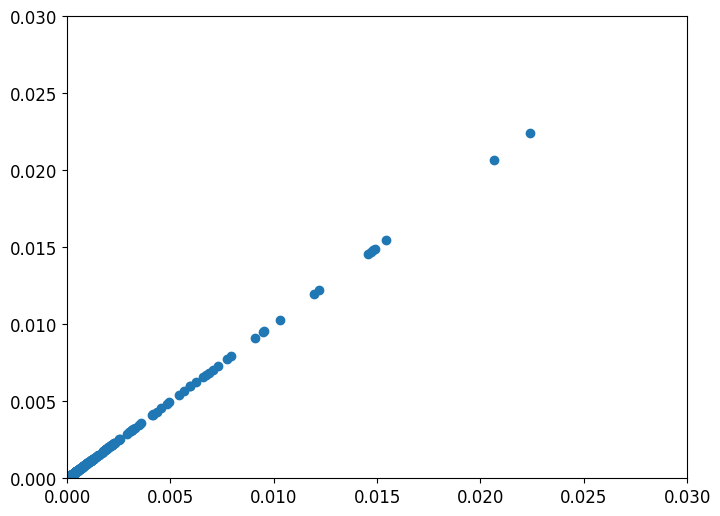

In [19]:
plt.scatter(PPE_grad_LWP_PRC,PPE_grad_LWP_PRC)
plt.xlim(0,0.03)
plt.ylim(0,0.03)

In [20]:
# # === Random Forest Emulator with Density Masking ===

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.mixture import GaussianMixture  
# import numpy as np

# def emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p, density_percentile=5, n_samples=10_000):
#     """
#     Train a Random Forest emulator and predict only within high-density regions 
#     of the training data, based on a Gaussian Mixture Model (GMM).

#     Parameters
#     ----------
#     x_p, y_p1, y_p2, y_p3, c_p : np.ndarray
#         Predictor and target arrays (same shape).
#     density_percentile : float, optional
#         Percentile cutoff for low-density masking (default=5 -> keep top 95% densest samples).
#     n_samples : int, optional
#         Number of GMM-sampled points to evaluate with the emulator.

#     Returns
#     -------
#     X_dense : np.ndarray
#         Predictor samples within high-density regions.
#     P_dense : np.ndarray
#         Emulator predictions corresponding to X_dense.
#     best_rf : sklearn.ensemble.RandomForestRegressor
#         Trained Random Forest model.
#     """

#     # --- Step 1: Determine valid (non-NaN) points ---
#     ind = ~np.isnan(x_p * y_p1 * y_p2 * y_p3 * c_p)
    
#     # --- Step 2: Stack predictors and target ---
#     X = np.column_stack((
#         x_p.data[ind], 
#         y_p1.data[ind],
#         y_p2.data[ind] * y_p3.data[ind]
#     ))
#     y = c_p[ind]

#     # --- Step 3: Train-test split ---
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=42
#     )

#     # --- Step 4: Define parameter grid for Random Forest ---
#     param_grid = {
#         'n_estimators': [100, 200],
#         'max_depth': [3, 5, None],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 3, 5],
#         'bootstrap': [True, False]
#     }

#     rf = RandomForestRegressor(random_state=13)

#     grid_search = GridSearchCV(
#         estimator=rf,
#         param_grid=param_grid,
#         cv=3,
#         scoring='r2',
#         verbose=0,
#         n_jobs=-1
#     )

#     grid_search.fit(X_train, y_train)
#     best_rf = grid_search.best_estimator_

#     # --- Step 5: Training performance ---
#     Ptrain = best_rf.predict(X_train)
#     r2 = r2_score(y_train, Ptrain)
#     mse = mean_squared_error(y_train, Ptrain)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_train, Ptrain)

#     print("\n=== Training Performance with Best RF ===")
#     print(f"R²:   {r2:.3f}")
#     print(f"MSE:  {mse:.3e}")
#     print(f"RMSE: {rmse:.3f}")
#     print(f"MAE:  {mae:.3f}")

#     # --- Step 6: Fit GMM to training data ---
#     gmm = GaussianMixture(n_components=3, random_state=0)
#     gmm.fit(X_train)

#     # --- Step 7: Sample new points and compute their density ---
#     X_new, _ = gmm.sample(n_samples)
#     log_density = gmm.score_samples(X_new)

#     # --- Step 8: Keep only high-density regions ---
#     density_threshold = np.percentile(log_density, density_percentile)
#     high_density_mask = log_density > density_threshold
#     X_dense = X_new[high_density_mask]
#     # --- bounding-box filtering ---
#     mask_in_bounds = np.ones(len(X_dense), dtype=bool)    
#     # x_p bounds
#     xmin, xmax = x_p.data[ind].min(), x_p.data[ind].max()
#     mask_in_bounds &= (X_dense[:,0] >= xmin) & (X_dense[:,0] <= xmax)    
#     # y_p1 bounds
#     y1min, y1max = y_p1.data[ind].min(), y_p1.data[ind].max()
#     mask_in_bounds &= (X_dense[:,1] >= y1min) & (X_dense[:,1] <= y1max)  
#     # y_p2*y_p3 bounds
#     ypn = y_p2.data[ind] * y_p3.data[ind]
#     zmin, zmax = ypn.min(), ypn.max()
#     mask_in_bounds &= (X_dense[:,2] >= zmin) & (X_dense[:,2] <= zmax)
#     # apply mask
#     X_dense_new = X_dense[mask_in_bounds]

#     P_dense = best_rf.predict(X_dense_new)

#     # print(f"\nKept {high_density_mask.sum():,} / {len(X_new):,} samples "
#     #       f"({100 * high_density_mask.sum()/len(X_new):.1f}%) "
#     #       f"within top {100 - density_percentile:.0f}% density region.")

#     # --- Evaluate on test data ---
#     Ptest = best_rf.predict(X_test)
#     r2_test = r2_score(y_test, Ptest)
#     print(f"Test R²: {r2_test:.3f}")

#     return X_dense_new, P_dense

In [21]:
# # dLWP_TSmap = dLWP_g.copy()

# # pe_metric = PPE_grad_LWP_PRC #PPE_grad_LWP_WCB

# def RFresults(min_lat, max_lat, FBcomp, cf, convergence_mask, SWD_da, dLWP_TSmap=dLWP_g, pe_metric=pe_metric, filtered_TOA_15=filtered_TOA_15):
#     print('lats: ', min_lat, max_lat)
    
#     # PPE_prior = []
#     # RF_prior = []
#     # RF_posterior = []
#     # constrain_arr = []
#     # MC_constrained = []

#     dLWP_TSmap_sel = sel_regime(dLWP_TSmap,min_lat,max_lat)
#     convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
#     SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
#     cf_sel = sel_regime(cf,min_lat,max_lat)

#     dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
#     convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
#     SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
#     cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
#     conv_filter = convergence_mask_sel*SWD_da_sel
#     filter_conv = lat_weight_mean(conv_filter)[0]

#     final_data_n = {
#         "xmap": pe_metric,
#         "ymap1": dLWP_TSmap_sel_mean,
#         "ymap2": convergence_mask_sel_mean,
#         "ymap3": SWD_da_sel_mean,
#         "clrmap": cf_mean,
#         "filter": filtered_TOA_15,
#         "filter2": filter_conv,
#     }
#     keys = list(final_data_n.keys())
#     common_members = final_data_n[keys[0]]['runs'].values
#     for name in keys:
#         common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
#     final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

#     sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
#     merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
#     from scipy.stats import norm
#     z_95 = norm.ppf(0.975)
#     obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
#     obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

#     print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)

#     PPE_conv_SWD = final_data['filter2']
#     constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

#     x_p = final_data['xmap']
#     y_p1 = final_data['ymap1']
#     y_p2 = final_data['ymap2']
#     y_p3 = final_data['ymap3']
#     y_p = y_p1*y_p2*y_p3
#     c_p = final_data['clrmap']
#     plt.figure(); plt.scatter(x_p.values, y_p.values, c=c_p.values, cmap='jet')
#     plt.colorbar(label=FBcomp)
#     plt.xlabel('∂LWP/∂P'); plt.ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$')
#     X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p.values)

#     pe_constrained = (X_new[:,0] >= lower_pe_metric) & (X_new[:,0] <= upper_pe_metric)
#     conv_constrained = (X_new[:,2] >= obs_constraint_lower) & (X_new[:,2] <= obs_constraint_upper)
#     both_constrained = pe_constrained & conv_constrained

#     return X_new[:,0], X_new[:,1]*X_new[:,2], P_new, both_constrained, conv_constrained

In [22]:
# weights (must sum to 1)
lat_bounds = [(0,20), (20, 50), (50, 90)]
weights = [np.sin(np.radians(max_lat)) - np.sin(np.radians(min_lat)) for min_lat, max_lat in lat_bounds]
weights = np.array(weights) / np.sum(weights)
w_sub, w_ext, w_trop = weights[1], weights[2], weights[0]

In [23]:
pe_maps_ol = load_xarray('pe_maps_ol')*86400  #[kgm-2day-1]

In [24]:
def SWD_da_func(convert, pe_maps_ol=pe_maps_ol, ocean=False):
    ### PD MC map
    PDMC_QFLX_da = pe_maps_ol.copy()
    
    ### converging area
    convergence_mask = PDMC_QFLX_da.where(PDMC_QFLX_da > 0, other=np.nan)
    # convergence_mask = PDMC_QFLX_da
    
    ### incoming solar flux  #downwelling SW flux at TOA
    SW_d_list = []
    run_numbers = []
    for fnum in range(263):
        try:
            fnums = f"{fnum:03d}"
            SWfn_list = np.load(f'/glade/derecho/scratch/geethma/PPE_PD_inSolar/maps_{fnums}.npz')  #PPE_PD_FSDTOA
            SW_maps = np.mean(SWfn_list['data'], axis=0)
            # SW_mean = lat_weight_mean(SW_maps)
            SW_d_list.append(SW_maps)
            run_numbers.append(fnum)
        except FileNotFoundError:
            print(f'{fnums} not available.')
            continue
    SW_d_list = np.array(SW_d_list)
    SWD_da = xr.DataArray(data=SW_d_list,
                          coords={'runs': run_numbers,
                                  'lat': SWfn_list['lat'],
                                  'lon': SWfn_list['lon']},
                          dims=['runs','lat','lon'])
    SWD_da = SWD_da.assign_coords(lon=(((SWD_da.lon + 180) % 360) - 180))
    SWD_da = SWD_da.sortby('lon')  # [Wm-2]
    if ocean:
        from get_land_mask import get_land_mask
        land_mask = get_land_mask(SWD_da['lat'], SWD_da['lon'])[0]
        land_mask_da = xr.DataArray(
            land_mask,
            coords={'lat': SWD_da.lat, 'lon': SWD_da.lon},
            dims=['lat', 'lon']
        )
        SWD_da = SWD_da * land_mask_da

    return convergence_mask, SWD_da


# add after Dec 24

In [25]:
convert = 1  #0.84  # multiplying factor to be consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)
convergence_mask, SWD_da = SWD_da_func(convert=convert)

<xarray.DataArray 'SWcld_tau' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
<xarray.DataArray 'LWcld_tau' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
<xarray.DataArray 'SWcld_amt' (runs: 262, lat: 192, lon: 288)>
dask.array<getitem, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunkt

/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethm

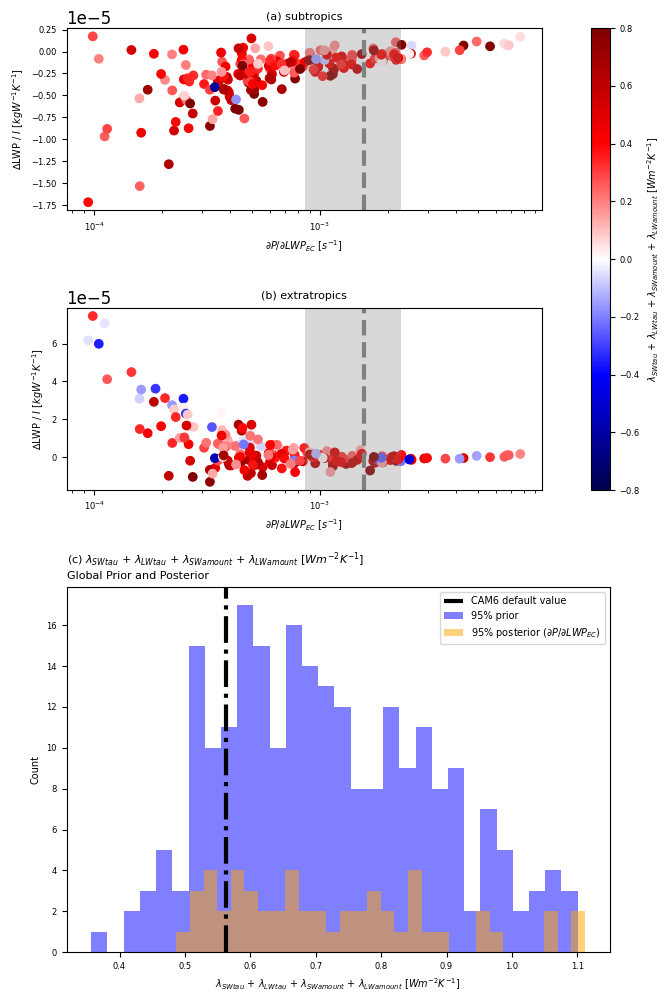

prior median is 0.728633275435282
posterior median is 0.7993329505402997
prior range is constrained by 0.1598876593058114


In [28]:
clabel = '$\\lambda_{SW tau}$ + $\\lambda_{LW tau}$ + $\\lambda_{SW amount}$ + $\\lambda_{LW amount}$ $[Wm^{-2}K^{-1}]$'
conCRE_g = load_cf('SWcld_tau', dGMT=dGMT, common_members=common_members) + load_cf('LWcld_tau', dGMT=dGMT, common_members=common_members) +load_cf('SWcld_amt', dGMT=dGMT, common_members=common_members) + load_cf('LWcld_amt', dGMT=dGMT, common_members=common_members)
global_prior, global_prior_sem, _ = lat_weight_mean(totCRE_g)

lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]

PPE_prior = {}

for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    dLWP_TSmap_sel = sel_regime(dLWP_g,min_lat,max_lat)
    # convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    cf_sel = sel_regime(conCRE_g,min_lat,max_lat)

    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    # convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
    # conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = SWD_da_sel_mean  #lat_weight_mean(conv_filter)[0]

    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        # "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": cf_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

    print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)

    PPE_conv_SWD = final_data['filter2']
    

    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    # y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1/y_p3  #y_p1*y_p2*y_p3
    c_p = final_data['clrmap']

    PPE_prior[regime] = {
        'pe': x_p.data,
        'dLWP': y_p.data,
        'conCRE_g': c_p.data
    }

constrained = np.where((PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper))
pe_constrained = np.where((x_p >= lower_pe_metric) & (x_p <= upper_pe_metric))
constrain_ind = np.intersect1d(pe_constrained, constrained)  # take the intersection of two constrained indices 


import matplotlib.gridspec as gridspec

# Set figure width to 11.4 or 17.8 cm  — PNAS width
fig = plt.figure(figsize=(17.8/2.54, 12))  # Adjust height as needed
title_num = ['(a) ', '(b) ', '(c) ']
# GridSpec: 3 rows, 4 columns (right 3 columns reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 2, width_ratios=[18, 0.7], height_ratios=[1, 1, 2], hspace=0.4, wspace=0.2)

nums = [[0,0], [0,1]]

# # --- Top two plots ---
for ax_n, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    ax = fig.add_subplot(gs[ax_n, 0])
    img = ax.scatter(PPE_prior[regime]['pe'], PPE_prior[regime]['dLWP'], c=PPE_prior[regime]['conCRE_g'], 
                     cmap='seismic', vmin=-0.8, vmax=0.8)
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle+' $[s^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('∆LWP / $I$ $[kgW^{-1}K^{-1}]$', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.set_xscale("log")
# --- Shared vertical colorbar for the two plots ---
p_cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the fourth column
cbar = plt.colorbar(img, cax=p_cbar_ax, orientation='vertical')
cbar.set_label(clabel, fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Constrained PDF (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span all columns
ax_scatter.axvline(global_prior[0], color='black', linestyle='-.', label='CAM6 default value')
# ax_scatter.axvspan(default-1.96*default_sem, default+1.96*default_sem, facecolor='black', alpha=0.3)

pr_bin_centers = p95(global_prior)
ax_scatter.hist(pr_bin_centers, bins=30, density=False, alpha=0.5, label='95% prior', color='b')


# pr_bin_centers, hist = plot_pdfs_diff(global_prior, 10)
# ax_scatter.plot(pr_bin_centers, hist, label='95% prior', color='b')
# print(np.max(pr_bin_centers), np.min(pr_bin_centers))

global_posterior = global_prior.isel(runs=constrain_ind)
po_bin_centers = p95(global_posterior)
ax_scatter.hist(po_bin_centers, bins=30, density=False, alpha=0.5, label='95% posterior ('+xtitle+')', color='orange')
# po_bin_centers, hist = plot_pdfs_diff(global_posterior, 10)
# ax_scatter.plot(po_bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# print(np.max(po_bin_centers), np.min(po_bin_centers))

ax_scatter.legend(fontsize=label_fontsize)

# # ax_scatter.set_xlabel('$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
plt.xlabel(clabel, fontsize=label_fontsize)
plt.ylabel('Count', fontsize=label_fontsize)
plt.title(title_num[2]+clabel+'\nGlobal Prior and Posterior', 
                     loc='left', fontsize=title_fontsize)
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.show()

prrange_m = (np.max(pr_bin_centers)-np.min(pr_bin_centers))/2
min = np.min(pr_bin_centers)
pr_med = min+prrange_m
print(f'prior median is {pr_med}')

porange_m = (np.max(po_bin_centers)-np.min(po_bin_centers))/2
min = np.min(po_bin_centers)
po_med = min+porange_m
print(f'posterior median is {po_med}')

constr = (prrange_m - porange_m)/prrange_m
print(f'prior range is constrained by {constr}')

(254, 64, 288)
(263, 64, 288)
(254, 64, 288)
(122, 576)
348.16961724527243 342.54733174227096 353.7919027482739
(254, 86, 288)
(263, 86, 288)
(254, 86, 288)
(162, 576)
227.77801576554933 222.48932670586674 233.0667048252319


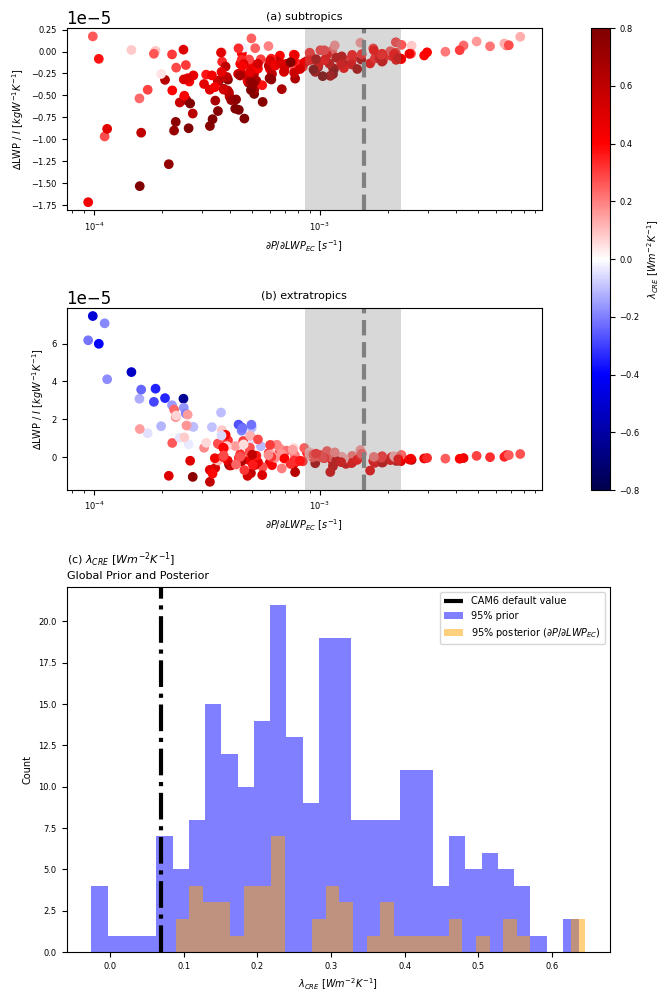

prior median is 0.3056472632510214
posterior median is 0.366978564186321
prior range is constrained by 0.16118512553172398


In [29]:
CRE_g = (load_xarray('dLWCREmap')+load_xarray('dSWCREmap'))/dGMT
global_prior, global_prior_sem, _ = lat_weight_mean(CRE_g)
clabel = '$\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$'

lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]

PPE_prior = {}
constrain_arr = {}

for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    dLWP_TSmap_sel = sel_regime(dLWP_g,min_lat,max_lat)
    # convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    cf_sel = sel_regime(CRE_g,min_lat,max_lat)

    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    # convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
    # conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = SWD_da_sel_mean  #lat_weight_mean(conv_filter)[0]

    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        # "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": cf_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

    print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)

    PPE_conv_SWD = final_data['filter2']

    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    # y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1/y_p3  #y_p1*y_p2*y_p3
    c_p = final_data['clrmap']
    # X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p)

    pe_constrained = np.where((x_p >= lower_pe_metric) & (x_p <= upper_pe_metric))

    PPE_prior[regime] = {
        'pe': x_p.data,
        'dLWP': y_p.data,
        'dCRE': c_p.data
    }

    constrained = np.where((PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper))
    pe_constrained = np.where((x_p >= lower_pe_metric) & (x_p <= upper_pe_metric))
    constrain_ind = np.intersect1d(pe_constrained, constrained)  # take the intersection of two constrained indices 
    constrain_arr[regime] = constrain_ind

import matplotlib.gridspec as gridspec
# Set figure width to 11.4 or 17.8 cm  — PNAS width
fig = plt.figure(figsize=(17.8/2.54, 12))  # Adjust height as needed
title_num = ['(a) ', '(b) ', '(c) ']
gs = gridspec.GridSpec(3, 2, width_ratios=[18, 0.7], height_ratios=[1, 1, 2], hspace=0.4, wspace=0.2)

nums = [[0,0], [0,1]]

# # --- Top two maps ---
for ax_n, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    ax = fig.add_subplot(gs[ax_n, 0])
    g = nums[ax_n][0]
    d = nums[ax_n][1]

    img = ax.scatter(PPE_prior[regime]['pe'], PPE_prior[regime]['dLWP'], c=PPE_prior[regime]['dCRE'], 
                     cmap='seismic', vmin=-0.8, vmax=0.8)
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle+' $[s^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('∆LWP / $I$ $[kgW^{-1}K^{-1}]$', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.set_xscale("log")
# --- Shared vertical colorbar for the two plots ---
p_cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the fourth column
cbar = plt.colorbar(img, cax=p_cbar_ax, orientation='vertical')
cbar.set_label(clabel, fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Constrained PDF (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span all columns
ax_scatter.axvline(global_prior[0], color='black', linestyle='-.', label='CAM6 default value')
# ax_scatter.axvspan(default-1.96*default_sem, default+1.96*default_sem, facecolor='black', alpha=0.3)

pr_bin_centers = p95(global_prior)
ax_scatter.hist(pr_bin_centers, bins=30, density=False, alpha=0.5, label='95% prior', color='b')


# pr_bin_centers, hist = plot_pdfs_diff(global_prior, 10)
# ax_scatter.plot(pr_bin_centers, hist, label='95% prior', color='b')
# print(np.max(pr_bin_centers), np.min(pr_bin_centers))

global_posterior = global_prior.isel(runs=constrain_ind)
po_bin_centers = p95(global_posterior)
ax_scatter.hist(po_bin_centers, bins=30, density=False, alpha=0.5, label='95% posterior ('+xtitle+')', color='orange')
# po_bin_centers, hist = plot_pdfs_diff(global_posterior, 10)
# ax_scatter.plot(po_bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# print(np.max(po_bin_centers), np.min(po_bin_centers))

ax_scatter.legend(fontsize=label_fontsize)

# # ax_scatter.set_xlabel('$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
plt.xlabel(clabel, fontsize=label_fontsize)
plt.ylabel('Count', fontsize=label_fontsize)
plt.title(title_num[2]+clabel+'\nGlobal Prior and Posterior', 
                     loc='left', fontsize=title_fontsize)
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.show()

prrange_m = (np.max(pr_bin_centers)-np.min(pr_bin_centers))/2
min = np.min(pr_bin_centers)
pr_med = min+prrange_m
print(f'prior median is {pr_med}')

porange_m = (np.max(po_bin_centers)-np.min(po_bin_centers))/2
min = np.min(po_bin_centers)
po_med = min+porange_m
print(f'posterior median is {po_med}')

constr = (prrange_m - porange_m)/prrange_m
print(f'prior range is constrained by {constr}')

(254, 64, 288)
(263, 64, 288)
(253, 64, 288)
(122, 576)
348.16961724527243 342.54733174227096 353.7919027482739
(254, 86, 288)
(263, 86, 288)
(253, 86, 288)
(162, 576)
227.77801576554933 222.48932670586674 233.0667048252319


/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


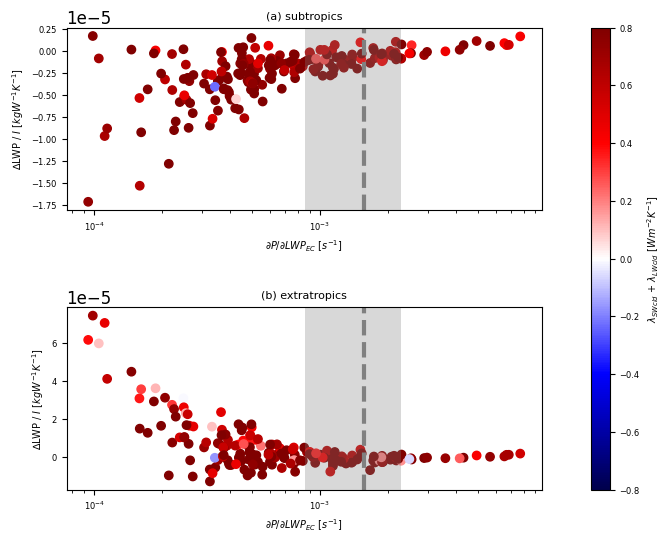

In [36]:
# clabel = '$\\lambda_{SW cld}$ + $\\lambda_{LW cld}$ $[Wm^{-2}K^{-1}]$'

# lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]

# PPE_prior = {}
# constrain_arr = {}

# for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
#     dLWP_TSmap_sel = sel_regime(dLWP_g,min_lat,max_lat)
#     # convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
#     SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
#     cf_sel = sel_regime(totCRE_g,min_lat,max_lat)

#     dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
#     # convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
#     SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
#     cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
#     # conv_filter = convergence_mask_sel*SWD_da_sel
#     filter_conv = SWD_da_sel_mean  #lat_weight_mean(conv_filter)[0]

#     final_data_n = {
#         "xmap": pe_metric,
#         "ymap1": dLWP_TSmap_sel_mean,
#         # "ymap2": convergence_mask_sel_mean,
#         "ymap3": SWD_da_sel_mean,
#         "clrmap": cf_mean,
#         "filter": filtered_TOA_15,
#         "filter2": filter_conv,
#     }
#     keys = list(final_data_n.keys())
#     common_members = final_data_n[keys[0]]['runs'].values
#     for name in keys:
#         common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
#     final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

#     sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
#     merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
#     from scipy.stats import norm
#     z_95 = norm.ppf(0.975)
#     obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
#     obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

#     print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)

#     PPE_conv_SWD = final_data['filter2']
#     constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

#     x_p = final_data['xmap']
#     y_p1 = final_data['ymap1']
#     # y_p2 = final_data['ymap2']
#     y_p3 = final_data['ymap3']
#     y_p = y_p1/y_p3  #y_p1*y_p2*y_p3
#     c_p = final_data['clrmap']
#     # X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p)

#     pe_constrained = np.where((x_p >= lower_pe_metric) & (x_p <= upper_pe_metric))
#     # conv_constrained = (X_new[:,2]*X_new[:,3] >= obs_constraint_lower) & (X_new[:,2]*X_new[:,3] <= obs_constraint_upper)
#     # both_constrained = pe_constrained & conv_constrained
#     # P_new_constrained = P_new[both_constrained]

#     PPE_prior[regime] = {
#         'pe': x_p.data,
#         'dLWP': y_p.data,
#         'totCRE_g': c_p.data
#     }
#     # RF_prior.append([X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], P_new])
#     # RF_posterior.append(P_new_constrained)
#     constrain_arr[regime] = c_p[pe_constrained]  # append the indices 

# # np.savez('final_figures/updated_RF_results.npz', PPE_prior=PPE_prior, RF_prior=RF_prior, RF_posterior=RF_posterior, runs=x_p.runs, constrain_arr=constrain_arr)

# # totdCRE_g = (load_xarray('dLWCREmap')+load_xarray('dSWCREmap'))/dGMT




# import matplotlib.gridspec as gridspec
# # lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]
# # regimes = ['subtropics', 'extratropics']
# # Set figure width to 11.4 or 17.8 cm  — PNAS width
# fig = plt.figure(figsize=(17.8/2.54, 12))  # Adjust height as needed
# title_num = ['(a) ', '(b) ', '(c) ']
# # GridSpec: 3 rows, 4 columns (right 3 columns reserved for shared colorbar on top row)
# gs = gridspec.GridSpec(3, 2, width_ratios=[18, 0.7], height_ratios=[1, 1, 2], hspace=0.4, wspace=0.2)

# nums = [[0,0], [0,1]]

# # data = np.load('final_figures/updated_RF_results.npz', allow_pickle=True)
# # PPE_prior = data['PPE_prior']
# # runs = data['runs']
# # constrain_arr = data['constrain_arr']

# # xtitle = '$∂P/∂LWP_{EC}$' #'$∂LWP/∂WCB_{EC}$'

# # # --- Top two maps ---
# # for ax_n in range(2):
# for ax_n, (min_lat, max_lat, regime) in enumerate(lat_ranges):
#     ax = fig.add_subplot(gs[ax_n, 0])
#     g = nums[ax_n][0]
#     d = nums[ax_n][1]
# #     regime = regimes[ax_n]

# #     # temp = RF_prior[ax_n+1]
#     img = ax.scatter(PPE_prior[regime]['pe'], PPE_prior[regime]['dLWP'], c=PPE_prior[regime]['totCRE_g'], 
#                      cmap='seismic', vmin=-0.8, vmax=0.8)
#     ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
#     ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
#     ax.set_xlabel(xtitle+' $[s^{-1}]$', fontsize=label_fontsize)
#     ax.set_ylabel('∆LWP / $I$ $[kgW^{-1}K^{-1}]$', fontsize=label_fontsize)
#     ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
#     ax.tick_params(axis='both', labelsize=tick_fontsize)
#     ax.set_xscale("log")


# p_cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the fourth column
# cbar = plt.colorbar(img, cax=p_cbar_ax, orientation='vertical')
# cbar.set_label(clabel, fontsize=label_fontsize)
# cbar.ax.tick_params(labelsize=tick_fontsize)

# #     p_temp = PPE_prior[ax_n+1]
# #     x_p = xr.DataArray(p_temp[0], dims=['runs'], coords={'runs': runs})
# #     y_p = xr.DataArray(p_temp[1], dims=['runs'], coords={'runs': runs})
# #     c_p = xr.DataArray(p_temp[2], dims=['runs'], coords={'runs': runs})

# #     p_img = ax.scatter(1/(x_p*86400), y_p, c=c_p, 
# #                         cmap='seismic', marker='s', s=72, vmin=-0.8, vmax=0.8)
# #     constrained = constrain_arr[ax_n+1]
# #     # ax.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
# #     #            edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
# #     ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
# #     ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
# #     ax.set_xlabel(xtitle+' $[s^{-1}]$', fontsize=label_fontsize)
# #     ax.set_ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
# #     ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
# #     ax.tick_params(axis='both', labelsize=tick_fontsize)
# #     # ax.set_yscale('log')




# # # --- Shared vertical colorbar for the two maps ---
# # # cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
# # # cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
# # # cbar.set_label('RF $\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# # # cbar.ax.tick_params(labelsize=tick_fontsize)
# # clabel = '$\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$'

# # p_cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the fourth column
# # cbar = plt.colorbar(p_img, cax=p_cbar_ax, orientation='vertical')
# # cbar.set_label(clabel, fontsize=label_fontsize)
# # cbar.ax.tick_params(labelsize=tick_fontsize)

# # # --- Constrained PDF (bottom row, full width) ---
# # ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span all columns
# # ax_scatter.axvline(default, color='black', linestyle='-.', label='CAM6 default value')
# # ax_scatter.axvspan(default-1.96*default_sem, default+1.96*default_sem, facecolor='black', alpha=0.3)

# # pr_bin_centers, hist = plot_pdfs_diff(global_prior, 10)
# # ax_scatter.plot(pr_bin_centers, hist, label='95% prior', color='b')
# # print(np.max(pr_bin_centers), np.min(pr_bin_centers))

# # po_bin_centers, hist = plot_pdfs_diff(global_posterior, 10)
# # ax_scatter.plot(po_bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# # print(np.max(po_bin_centers), np.min(po_bin_centers))


# # ax_scatter.legend(fontsize=label_fontsize)

# # # ax_scatter.set_xlabel('$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# # plt.xlabel(clabel + '$[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# # plt.ylabel('Density', fontsize=label_fontsize)
# # plt.title(title_num[2]+clabel+'\nArea-weighted Global Prior and Posterior', 
# #                      loc='left', fontsize=title_fontsize)
# # plt.tick_params(axis='both', labelsize=tick_fontsize)
# # plt.show()


In [35]:
pr_bin_centers

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [36]:
po_bin_centers

array([0.11695815, 0.17251824, 0.22807833, 0.28363843, 0.33919852,
       0.39475861, 0.4503187 , 0.5058788 , 0.56143889, 0.61699898])

/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


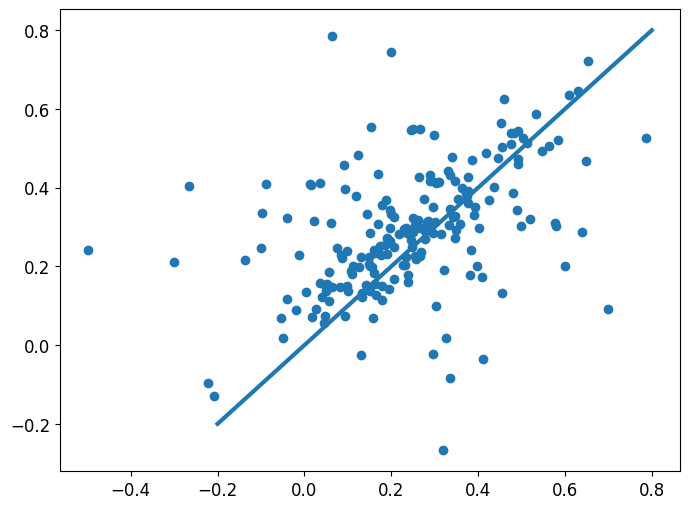

In [41]:
plt.scatter(lat_weight_mean(conCRE_g)[0], CRE_g_mean.sel(runs=conCRE_g.runs))
plt.plot([-0.2,0.8], [-0.2, 0.8])

# before Dec 24

<xarray.DataArray 'SWcld_tau' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
<xarray.DataArray 'LWcld_tau' (runs: 262, lat: 192, lon: 288)>
dask.array<transpose, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 254 255 256 257 258 259 260 261
<xarray.DataArray 'SWcld_amt' (runs: 262, lat: 192, lon: 288)>
dask.array<getitem, shape=(262, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunkt

/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



=== Training Performance with Best RF ===
R²:   0.343
MSE:  3.992e-02
RMSE: 0.200
MAE:  0.140
Test R²: -0.034
lats:  50 90
(254, 86, 288)
(254, 86, 288)
(263, 86, 288)
(253, 86, 288)
(162, 576)
256.8365084498096 238.8468865316165 274.82613036800274


/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))



=== Training Performance with Best RF ===
R²:   0.409
MSE:  4.608e-02
RMSE: 0.215
MAE:  0.162
Test R²: 0.028


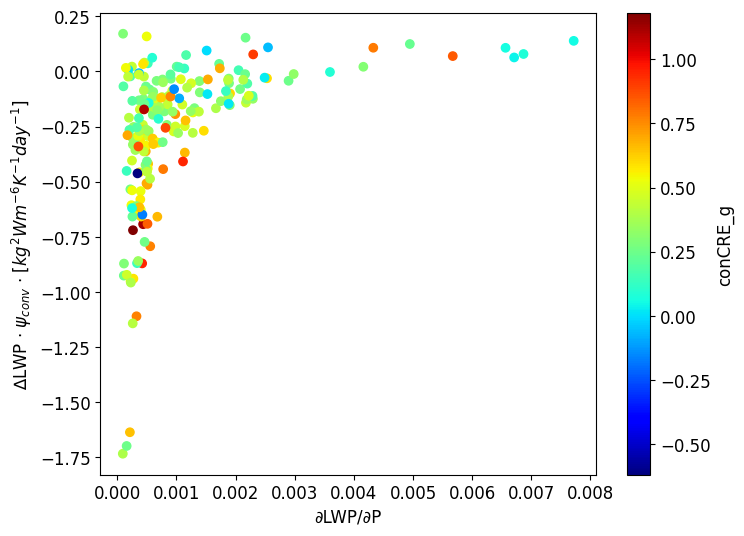

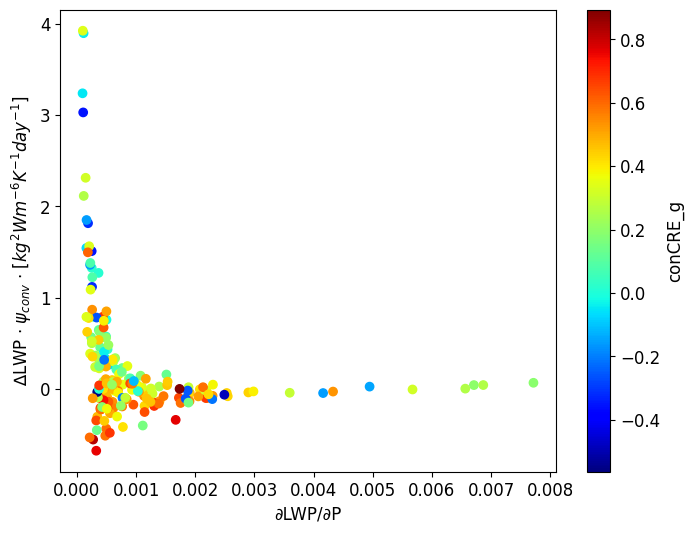

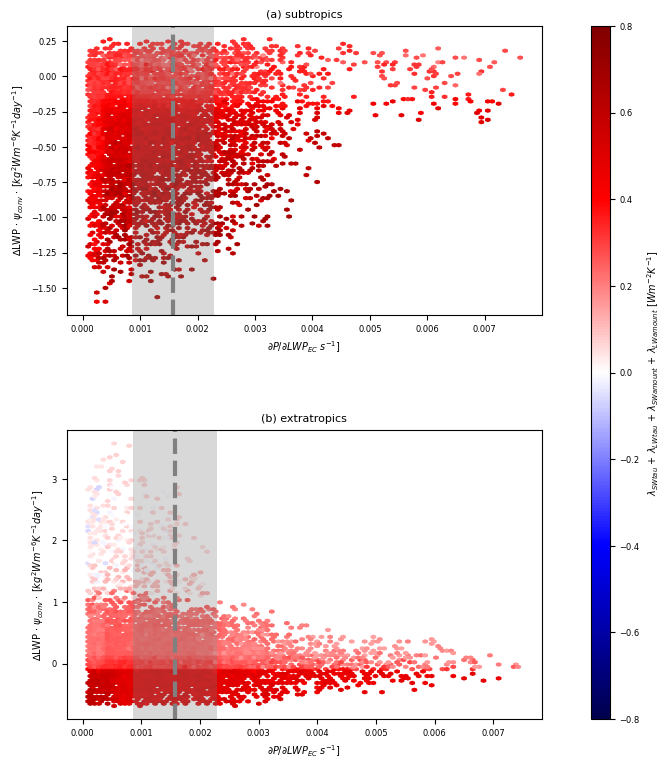

In [26]:
conCRE_g = load_cf('SWcld_tau', dGMT=dGMT, common_members=common_members) + load_cf('LWcld_tau', dGMT=dGMT, common_members=common_members) +load_cf('SWcld_amt', dGMT=dGMT, common_members=common_members) + load_cf('LWcld_amt', dGMT=dGMT, common_members=common_members)
#-----------------------------------------------------

convert = 1  #0.84  # multiplying factor to be consistent with abrupt4xco2 (Fig 1e in Qin et al 2022)
convergence_mask, SWD_da = SWD_da_func(convert=convert)
#-----------------------------------------------------

FBcomp = 'conCRE_g'
min_lat, max_lat = 20, 50
sub_RF_precipeff_cyc, sub_RF_dLWP, sub_RF_CF, sub_constrained_indices, sub_conv_constrained = RFresults(min_lat, max_lat, FBcomp, conCRE_g, convergence_mask, SWD_da)
min_lat, max_lat = 50, 90
ext_RF_precipeff_cyc, ext_RF_dLWP, ext_RF_CF, ext_constrained_indices, ext_conv_constrained = RFresults(min_lat, max_lat, FBcomp, conCRE_g, convergence_mask, SWD_da)
#-----------------------------------------------------

import matplotlib.gridspec as gridspec
lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]
regimes = ['subtropics', 'extratropics']
# Set figure width to 11.4 or 17.8 cm  — PNAS width
fig = plt.figure(figsize=(17.8/2.54, 9))  # Adjust height as needed
title_num = ['(a) ', '(b) ', '(c) ']
# GridSpec: 3 rows, 4 columns (right 3 columns reserved for shared colorbar on top row)
gs = gridspec.GridSpec(2, 2, width_ratios=[18, 0.7], height_ratios=[1, 1], hspace=0.4, wspace=0.2)

nums = [[0,0], [0,1]]

x_p_list = [sub_RF_precipeff_cyc, ext_RF_precipeff_cyc]
y_p_list = [sub_RF_dLWP, ext_RF_dLWP]
c_p_list = [sub_RF_CF, ext_RF_CF]

for ax_n in range(2):
    ax = fig.add_subplot(gs[ax_n, 0])
    g = nums[ax_n][0]
    d = nums[ax_n][1]
    regime = regimes[ax_n]

    x_p = x_p_list[ax_n]
    y_p = y_p_list[ax_n]
    c_p = c_p_list[ax_n]

    p_img = ax.hexbin(x_p, y_p, C=c_p, 
                        cmap='seismic', vmin=-0.8, vmax=0.8)
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle+' $s^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
p_cbar_ax = fig.add_subplot(gs[:, 1])  # Span both top rows in the fourth column
cbar = plt.colorbar(p_img, cax=p_cbar_ax, orientation='vertical')
cbar.set_label('$\\lambda_{SW tau}$ + $\\lambda_{LW tau}$ + $\\lambda_{SW amount}$ + $\\lambda_{LW amount}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

plt.savefig(fig_dir+'RFplot.png',
            bbox_inches='tight', facecolor='white', dpi=600)
plt.show()


In [31]:
# def prior_post(sub_RF_CF, sub_constrained_indices=None):
#     if sub_constrained_indices is not None:
#         print('if')
#         sub_RF_CF_post = sub_RF_CF[sub_constrained_indices]  # Posterior data (constrained subset)  
#     else:
#         print('else')
#         sub_RF_CF_post = sub_RF_CF
#     post_samples = np.random.choice(sub_RF_CF_post, 500, replace=True)
#     return post_samples

In [33]:
def prior_post(sub_RF_CF, sub_constrained_indices=None):
    if sub_constrained_indices is not None:
        print('if')
        sub_RF_CF_post = sub_RF_CF[sub_constrained_indices]  # Posterior data (constrained subset)  
        low, high = np.nanpercentile(sub_RF_CF_post, [5, 95])  # 5th–95th percentile range of posterior
    else:
        print('else')
        low, high = np.nanpercentile(sub_RF_CF, [5, 95])
    post_samples = np.random.uniform(low, high, 1000)  # Draw 1000 samples uniformly within this range
    return post_samples

In [28]:
def global_prior_posterior(
    sub_RF_CF_tot, ext_RF_CF_tot, tr_RF_CF_tot, 
    sub_RF_CF, ext_RF_CF, 
    sub_constrained_indices, ext_constrained_indices, 
    w_sub, w_ext, w_trop):

    idx = np.random.choice(len(sub_RF_CF_tot), 5000, replace=False)
    sub_subset = sub_RF_CF_tot[idx]
    idx = np.random.choice(len(ext_RF_CF_tot), 5000, replace=False)
    ext_subset = ext_RF_CF_tot[idx]
    idx = np.random.choice(len(tr_RF_CF_tot), 5000, replace=False)
    tr_subset = tr_RF_CF_tot[idx]
    global_prior = w_sub*sub_subset + w_ext*ext_subset + w_trop*tr_subset  # global prior sample
    
    sub_post_samples = prior_post(sub_RF_CF, sub_constrained_indices) + prior_post(sub_RF_CF_tot-sub_RF_CF)  # 1000 posterior values for subtropics
    ext_post_samples = prior_post(ext_RF_CF, ext_constrained_indices) + prior_post(ext_RF_CF_tot-ext_RF_CF)  # 1000 posterior value for extratropics
    tr_post_samples = prior_post(tr_RF_CF_tot)  # 1000 value from the prior for tropics
    global_posterior = w_sub*sub_post_samples + w_ext*ext_post_samples + w_trop*tr_post_samples
    
    return global_prior, global_posterior

lats:  20 50
(254, 64, 288)
(254, 64, 288)
(263, 64, 288)
(253, 64, 288)
(122, 576)
349.6441715192321 323.90625285863274 375.38209017983144


/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



=== Training Performance with Best RF ===
R²:   0.301
MSE:  5.184e-02
RMSE: 0.228
MAE:  0.161
Test R²: -0.076
lats:  0 20
(254, 42, 288)
(254, 42, 288)
(263, 42, 288)
(253, 42, 288)
(81, 576)
1082.0025788794226 992.9501967281166 1171.0549610307285


/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



=== Training Performance with Best RF ===
R²:   0.287
MSE:  5.254e-02
RMSE: 0.229
MAE:  0.182
Test R²: 0.122
lats:  50 90
(254, 86, 288)
(254, 86, 288)
(263, 86, 288)
(253, 86, 288)
(162, 576)
256.8365084498096 238.8468865316165 274.82613036800274


/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



=== Training Performance with Best RF ===
R²:   0.417
MSE:  5.056e-02
RMSE: 0.225
MAE:  0.172
Test R²: -0.016
if
else
if
else
else
------regime: subtropics
(254, 64, 288)
(254, 64, 288)
(263, 64, 288)
(253, 64, 288)
(253, 64, 288)
(122, 576)
349.6441715192321 323.90625285863274 375.38209017983144


/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


------regime: extratropics
(254, 86, 288)
(254, 86, 288)
(263, 86, 288)
(253, 86, 288)
(253, 86, 288)
(162, 576)
256.8365084498096 238.8468865316165 274.82613036800274


/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/glade/u/home/geethma/.conda/envs/wgh/lib/python3.9/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in add
  return func(*(_execute_task(a, cache) for a in args))


95th percentile taken
0.8860265716138165 0.6388863112258334
95th percentile taken
0.8796996245743277 0.6730937166818084


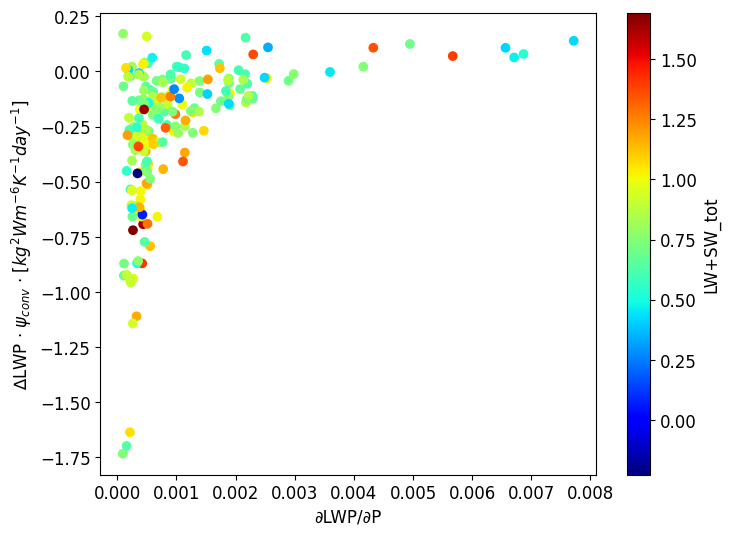

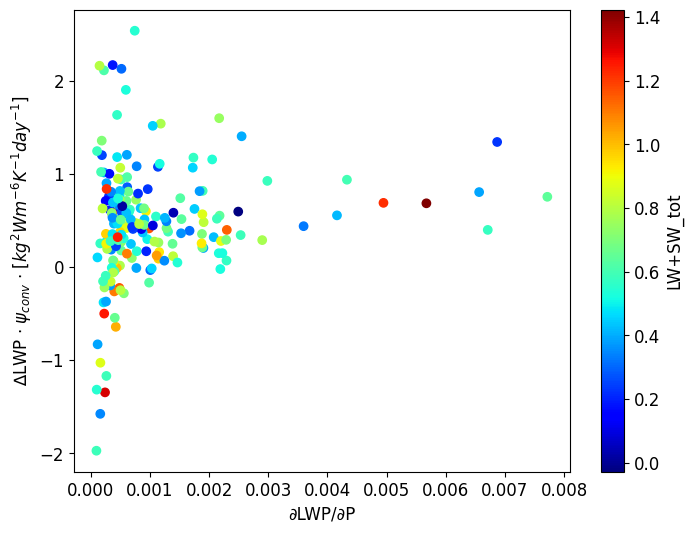

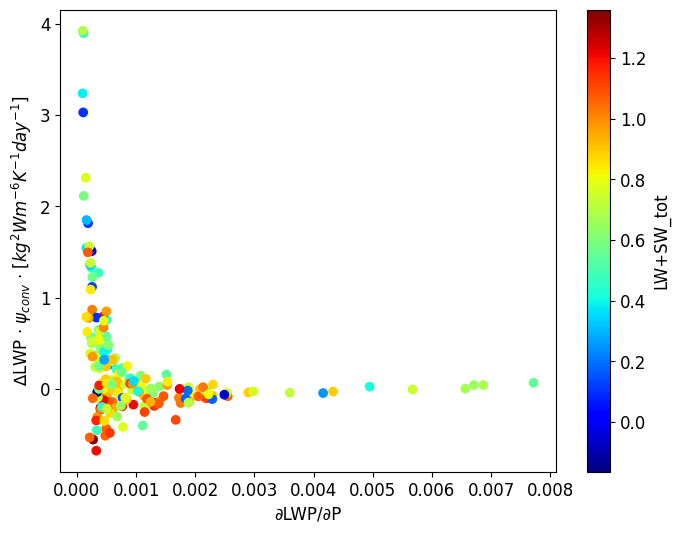

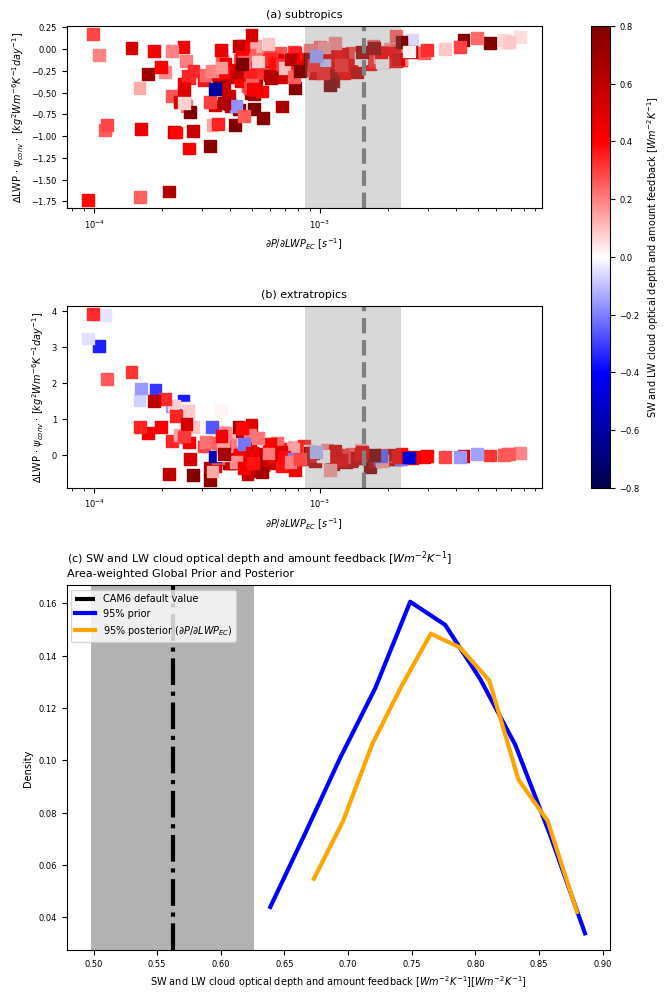

In [36]:
### total cloud feedback
FBcomp = 'LW+SW_tot'
# total from the subtropics
min_lat, max_lat = 20, 50
_, _, sub_RF_CF_tot, _, _ = RFresults(min_lat, max_lat, FBcomp, totCRE_g, convergence_mask, SWD_da)
# total from the tropics
min_lat, max_lat = 0, 20
_, _, tr_RF_CF_tot, _, _ = RFresults(min_lat, max_lat, FBcomp, totCRE_g, convergence_mask, SWD_da)
# total from the extratropics
min_lat, max_lat = 50, 90
_, _, ext_RF_CF_tot, _, _ = RFresults(min_lat, max_lat, FBcomp, totCRE_g, convergence_mask, SWD_da)
#-----------------------------------------------------

global_prior, global_posterior = global_prior_posterior(
    sub_RF_CF_tot, ext_RF_CF_tot, tr_RF_CF_tot, 
    sub_RF_CF, ext_RF_CF, 
    sub_constrained_indices, ext_constrained_indices, 
    w_sub, w_ext, w_trop)
#-----------------------------------------------------

import matplotlib.gridspec as gridspec
lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]

# Set figure width to 11.4 or 17.8 cm  — PNAS width
fig = plt.figure(figsize=(17.8/2.54, 12))  # Adjust height as needed
title_num = ['(a) ', '(b) ', '(c) ']
# GridSpec: 3 rows, 4 columns (right 3 columns reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 2, width_ratios=[18, 0.7], height_ratios=[1, 1, 2], hspace=0.4, wspace=0.2)

nums = [[0,0], [0,1]]
xtitle = '$∂P/∂LWP_{EC}$'

convert = 1
convergence_mask, SWD_da = SWD_da_func(convert=convert)

for ax_n, (min_lat, max_lat, regime_name) in enumerate(lat_ranges):
    print(f"------regime: {regime_name}")
    dLWP_TSmap_sel = sel_regime(dLWP_g,min_lat,max_lat)
    convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    sel_conCRE_g = sel_regime(conCRE_g, min_lat, max_lat)
    sel_totCRE_g = sel_regime(totCRE_g, min_lat, max_lat)
    
    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    sel_conCRE_g_mean, cf_sem, cf_std = lat_weight_mean(sel_conCRE_g)
    sel_totCRE_g_mean, cf_sem, cf_std = lat_weight_mean(sel_totCRE_g)
    conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = lat_weight_mean(conv_filter)[0]
    
    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": sel_conCRE_g_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}
    
    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values
    
    print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)
    
    PPE_conv_SWD = final_data['filter2']
    constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)
    
    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1*y_p2*y_p3
    c_p = final_data['clrmap']

    ax = fig.add_subplot(gs[ax_n, 0])
    g = nums[ax_n][0]
    d = nums[ax_n][1]
    p_img = ax.scatter(x_p, y_p, c=c_p, 
                        cmap='seismic', marker='s', s=72, vmin=-0.8, vmax=0.8)
    # constrained = constrain_arr[ax_n+1]
    # ax.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
    #            edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle+' $[s^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime_name, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.set_xscale("log")

clabel = 'SW and LW cloud optical depth and amount feedback $[Wm^{-2}K^{-1}]$'
p_cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the fourth column
cbar = plt.colorbar(p_img, cax=p_cbar_ax, orientation='vertical')
cbar.set_label(clabel, fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# --- Constrained PDF (bottom row, full width) ---
ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span all columns
ax_scatter.axvline(default, color='black', linestyle='-.', label='CAM6 default value')
ax_scatter.axvspan(default-1.96*default_sem, default+1.96*default_sem, facecolor='black', alpha=0.3)

pr_bin_centers, hist = plot_pdfs_diff(global_prior, 10)
ax_scatter.plot(pr_bin_centers, hist, label='95% prior', color='b')
print(np.max(pr_bin_centers), np.min(pr_bin_centers))

po_bin_centers, hist = plot_pdfs_diff(global_posterior, 10)
ax_scatter.plot(po_bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
print(np.max(po_bin_centers), np.min(po_bin_centers))


ax_scatter.legend(fontsize=label_fontsize)

# ax_scatter.set_xlabel('$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
plt.xlabel(clabel + '$[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
plt.ylabel('Density', fontsize=label_fontsize)
plt.title(title_num[2]+clabel+'\nArea-weighted Global Prior and Posterior', 
                     loc='left', fontsize=title_fontsize)
plt.tick_params(axis='both', labelsize=tick_fontsize)
plt.show()

In [35]:
prrange_m = (np.max(pr_bin_centers)-np.min(pr_bin_centers))/2
min = np.min(pr_bin_centers)
pr_med = min+prrange_m
print(f'prior median is {pr_med}')

porange_m = (np.max(po_bin_centers)-np.min(po_bin_centers))/2
min = np.min(po_bin_centers)
po_med = min+porange_m
print(f'posterior median is {po_med}')

constr = (prrange_m - porange_m)/prrange_m
print(f'prior range is constrained by {constr}')

prior median is 0.762951699059512
posterior median is 0.7701246414678766
prior range is constrained by 0.12303903077111536


In [42]:
CRE_g = (load_xarray('dLWCREmap')+load_xarray('dSWCREmap'))/dGMT
CRE_g_mean = lat_weight_mean(CRE_g)[0]
clabel = 'SW and LW cloud optical depth and amount feedback $[Wm^{-2}K^{-1}]$'

In [50]:
lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]

PPE_prior = {}
constrain_arr = {}

for idx, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    dLWP_TSmap_sel = sel_regime(dLWP_g,min_lat,max_lat)
    convergence_mask_sel = sel_regime(convergence_mask,min_lat,max_lat)
    SWD_da_sel = sel_regime(SWD_da,min_lat,max_lat)
    cf_sel = sel_regime(CRE_g,min_lat,max_lat)

    dLWP_TSmap_sel_mean = lat_weight_mean(dLWP_TSmap_sel)[0]
    convergence_mask_sel_mean = lat_weight_mean(convergence_mask_sel)[0]
    SWD_da_sel_mean = lat_weight_mean(SWD_da_sel)[0]
    cf_mean, cf_sem, cf_std = lat_weight_mean(cf_sel)
    conv_filter = convergence_mask_sel*SWD_da_sel
    filter_conv = lat_weight_mean(conv_filter)[0]

    final_data_n = {
        "xmap": pe_metric,
        "ymap1": dLWP_TSmap_sel_mean,
        "ymap2": convergence_mask_sel_mean,
        "ymap3": SWD_da_sel_mean,
        "clrmap": cf_mean,
        "filter": filtered_TOA_15,
        "filter2": filter_conv,
    }
    keys = list(final_data_n.keys())
    common_members = final_data_n[keys[0]]['runs'].values
    for name in keys:
        common_members = np.intersect1d(common_members, final_data_n[name]['runs'].values)
    final_data = {name: ds.sel(runs=common_members) for name, ds in final_data_n.items()}

    sel_merra_conv_sw = sel_regime(merra_conv_sw, min_lat, max_lat)
    merraMC_mean, merraMC_sem, _ = lat_weight_mean(sel_merra_conv_sw)
    from scipy.stats import norm
    z_95 = norm.ppf(0.975)
    obs_constraint_lower = merraMC_mean.values - z_95 * merraMC_sem.values
    obs_constraint_upper = merraMC_mean.values + z_95 * merraMC_sem.values

    print(merraMC_mean.values, obs_constraint_lower, obs_constraint_upper)

    PPE_conv_SWD = final_data['filter2']
    constrained = (PPE_conv_SWD.values >= obs_constraint_lower) & (PPE_conv_SWD.values <= obs_constraint_upper)

    x_p = final_data['xmap']
    y_p1 = final_data['ymap1']
    y_p2 = final_data['ymap2']
    y_p3 = final_data['ymap3']
    y_p = y_p1*y_p2*y_p3
    c_p = final_data['clrmap']
    # X_new, P_new = emulate_regimes(x_p, y_p1, y_p2, y_p3, c_p)

    pe_constrained = np.where((x_p >= lower_pe_metric) & (x_p <= upper_pe_metric))
    # conv_constrained = (X_new[:,2]*X_new[:,3] >= obs_constraint_lower) & (X_new[:,2]*X_new[:,3] <= obs_constraint_upper)
    # both_constrained = pe_constrained & conv_constrained
    # P_new_constrained = P_new[both_constrained]

    PPE_prior[regime] = {
        'pe': x_p.data,
        'dLWP': y_p.data,
        'dCRE': c_p.data
    }
    # RF_prior.append([X_new[:,0], X_new[:,1]*X_new[:,2]*X_new[:,3], P_new])
    # RF_posterior.append(P_new_constrained)
    constrain_arr[regime] = CRE_g_mean[pe_constrained]  # append the indices 

# np.savez('final_figures/updated_RF_results.npz', PPE_prior=PPE_prior, RF_prior=RF_prior, RF_posterior=RF_posterior, runs=x_p.runs, constrain_arr=constrain_arr)


(254, 64, 288)
(254, 64, 288)
(263, 64, 288)
(254, 64, 288)
(122, 576)
349.6441715192321 323.90625285863274 375.38209017983144
(254, 86, 288)
(254, 86, 288)
(263, 86, 288)
(254, 86, 288)
(162, 576)
256.8365084498096 238.8468865316165 274.82613036800274


95th percentile taken
0.8856731041687541 0.6394621632660045
95th percentile taken
0.8653657861170737 0.6282438259166352


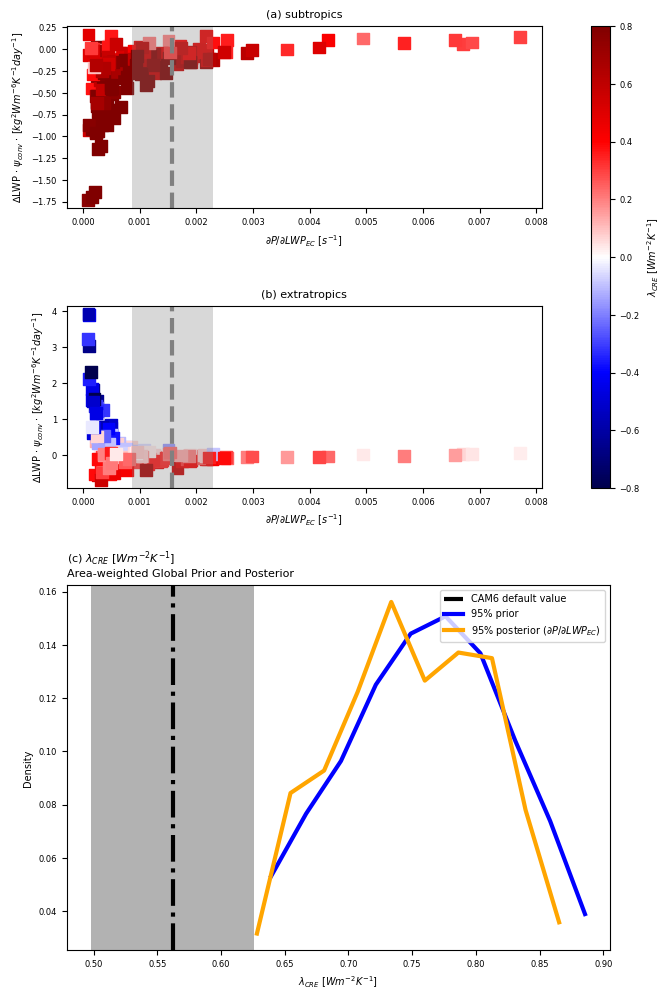

In [30]:
# totdCRE_g = (load_xarray('dLWCREmap')+load_xarray('dSWCREmap'))/dGMT




import matplotlib.gridspec as gridspec
lat_ranges = [(20, 50, 'subtropics'), (50, 90, 'extratropics')]
regimes = ['subtropics', 'extratropics']
# Set figure width to 11.4 or 17.8 cm  — PNAS width
fig = plt.figure(figsize=(17.8/2.54, 12))  # Adjust height as needed
title_num = ['(a) ', '(b) ', '(c) ']
# GridSpec: 3 rows, 4 columns (right 3 columns reserved for shared colorbar on top row)
gs = gridspec.GridSpec(3, 2, width_ratios=[18, 0.7], height_ratios=[1, 1, 2], hspace=0.4, wspace=0.2)

nums = [[0,0], [0,1]]

# data = np.load('final_figures/updated_RF_results.npz', allow_pickle=True)
# PPE_prior = data['PPE_prior']
# runs = data['runs']
# constrain_arr = data['constrain_arr']

# xtitle = '$∂P/∂LWP_{EC}$' #'$∂LWP/∂WCB_{EC}$'

# # --- Top two maps ---
# for ax_n in range(2):
for ax_n, (min_lat, max_lat, regime) in enumerate(lat_ranges):
    ax = fig.add_subplot(gs[ax_n, 0])
    g = nums[ax_n][0]
    d = nums[ax_n][1]
#     regime = regimes[ax_n]

#     # temp = RF_prior[ax_n+1]
    img = ax.scatter(PPE_prior[regime]['pe'], PPE_prior[regime]['dLWP'], c=PPE_prior[regime]['dCRE'], 
                     cmap='seismic', vmin=-0.8, vmax=0.8)
    ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
    ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
    ax.set_xlabel(xtitle+' $[s^{-1}]$', fontsize=label_fontsize)
    ax.set_ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
    ax.set_title(title_num[ax_n]+regime_name, fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.set_xscale("log")


p_cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the fourth column
cbar = plt.colorbar(p_img, cax=p_cbar_ax, orientation='vertical')
cbar.set_label(clabel, fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

#     p_temp = PPE_prior[ax_n+1]
#     x_p = xr.DataArray(p_temp[0], dims=['runs'], coords={'runs': runs})
#     y_p = xr.DataArray(p_temp[1], dims=['runs'], coords={'runs': runs})
#     c_p = xr.DataArray(p_temp[2], dims=['runs'], coords={'runs': runs})

#     p_img = ax.scatter(1/(x_p*86400), y_p, c=c_p, 
#                         cmap='seismic', marker='s', s=72, vmin=-0.8, vmax=0.8)
#     constrained = constrain_arr[ax_n+1]
#     # ax.scatter(x_p.sel(runs=constrained), y_p.sel(runs=constrained), 
#     #            edgecolor='black', facecolor='none', marker='s', s=100, linewidth=1.5)
#     ax.axvline(x=obs_pe_metric, color='grey', linestyle='--')
#     ax.axvspan(lower_pe_metric, upper_pe_metric, facecolor='grey', alpha=0.3)
#     ax.set_xlabel(xtitle+' $[s^{-1}]$', fontsize=label_fontsize)
#     ax.set_ylabel('∆LWP $\cdot$ $\psi_{conv}$ $\cdot$ $[kg^2Wm^{-6}K^{-1}day^{-1}]$', fontsize=label_fontsize)
#     ax.set_title(title_num[ax_n]+regime, fontsize=title_fontsize)
#     ax.tick_params(axis='both', labelsize=tick_fontsize)
#     # ax.set_yscale('log')




# # --- Shared vertical colorbar for the two maps ---
# # cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the second column
# # cbar = plt.colorbar(img, cax=cbar_ax, orientation='vertical')
# # cbar.set_label('RF $\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# # cbar.ax.tick_params(labelsize=tick_fontsize)
# clabel = '$\\lambda_{CRE}$ $[Wm^{-2}K^{-1}]$'

# p_cbar_ax = fig.add_subplot(gs[0:2, 1])  # Span both top rows in the fourth column
# cbar = plt.colorbar(p_img, cax=p_cbar_ax, orientation='vertical')
# cbar.set_label(clabel, fontsize=label_fontsize)
# cbar.ax.tick_params(labelsize=tick_fontsize)

# # --- Constrained PDF (bottom row, full width) ---
# ax_scatter = fig.add_subplot(gs[2, :])  # Bottom row, span all columns
# ax_scatter.axvline(default, color='black', linestyle='-.', label='CAM6 default value')
# ax_scatter.axvspan(default-1.96*default_sem, default+1.96*default_sem, facecolor='black', alpha=0.3)

# pr_bin_centers, hist = plot_pdfs_diff(global_prior, 10)
# ax_scatter.plot(pr_bin_centers, hist, label='95% prior', color='b')
# print(np.max(pr_bin_centers), np.min(pr_bin_centers))

# po_bin_centers, hist = plot_pdfs_diff(global_posterior, 10)
# ax_scatter.plot(po_bin_centers, hist, label='95% posterior ('+xtitle+')', color='orange')
# print(np.max(po_bin_centers), np.min(po_bin_centers))


# ax_scatter.legend(fontsize=label_fontsize)

# # ax_scatter.set_xlabel('$\\lambda_{cld}$ $[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# plt.xlabel(clabel + '$[Wm^{-2}K^{-1}]$', fontsize=label_fontsize)
# plt.ylabel('Density', fontsize=label_fontsize)
# plt.title(title_num[2]+clabel+'\nArea-weighted Global Prior and Posterior', 
#                      loc='left', fontsize=title_fontsize)
# plt.tick_params(axis='both', labelsize=tick_fontsize)
# plt.show()
